In [59]:
%load_ext Cython

The Cython extension is already loaded. To reload it, use:
  %reload_ext Cython


MarchingSquareCythonArray
=========================

In [60]:
%%cython --cplus

import cython
import numpy
cimport numpy as cnumpy

from libcpp.vector cimport vector
from libc.math cimport fabs
cdef double EPSILON = numpy.finfo(numpy.float64).eps

cdef cnumpy.int8_t[2] *EDGE_TO_POINT = [[0, 0], [1, 0], [1, 1], [0, 1], [0, 0]]
cdef cnumpy.int8_t[5] *CELL_TO_EDGE = [
                                       # array of index containing
                                       # id0: number of segments (up to 2)
                                       # id1: index of the start of the 1st edge
                                       # id2: index of the end of the 1st edge
                                       # id3: index of the start of the 2nd edge
                                       # id4: index of the end of the 2nd edge
                                       [0, 0, 0, 0, 0],  # Case 0: 0000: nothing
                                       [1, 0, 3, 0, 0],  # Case 1: 0001
                                       [1, 0, 1, 0, 0],  # Case 2: 0010
                                       [1, 1, 3, 0, 0],  # Case 3: 0011

                                       [1, 1, 2, 0, 0],  # Case 4: 0100
                                       [2, 0, 1, 2, 3],  # Case 5: 0101 > ambiguous
                                       [1, 0, 2, 0, 0],  # Case 6: 0110
                                       [1, 2, 3, 0, 0],  # Case 7: 0111

                                       [1, 2, 3, 0, 0],  # Case 8: 1000
                                       [1, 0, 2, 0, 0],  # Case 9: 1001
                                       [2, 0, 3, 1, 2],  # Case 10: 1010 > ambiguous
                                       [1, 1, 2, 0, 0],  # Case 11: 1011

                                       [1, 1, 3, 0, 0],  # Case 12: 1100
                                       [1, 0, 1, 0, 0],  # Case 13: 1101
                                       [1, 0, 3, 0, 0],  # Case 14: 1110
                                       [0, 0, 0, 0, 0],  # Case 15: 1111
                                      ]


cdef struct next_segment_t:
    int x
    int y
    int index
    int edge


cdef class MarchingSquareCythonArray(object):

    cdef cnumpy.float32_t[:, :] _image
    cdef cnumpy.int8_t[:, :] _mask
    cdef vector[cnumpy.float32_t] _forward_points
    cdef vector[cnumpy.float32_t] _backward_points
    cdef cnumpy.uint8_t[:, :] _indexes

    def __init__(self, image, mask=None):
        cdef:
            int wh
        self._image = numpy.ascontiguousarray(image, numpy.float32)
        if mask is not None:
            self._mask = numpy.ascontiguousarray(mask, numpy.int8)
            assert(image.shape == mask.shape)
        else:
            self._mask = None
        with nogil:
            wh = self._image.shape[0] + self._image.shape[1]
            self._forward_points.reserve(wh)
            self._backward_points.reserve(wh)

    @cython.boundscheck(False)
    @cython.wraparound(False)
    @cython.cdivision(True)
    cdef _create_marching_squares(self, double isovalue):
        cdef:
            bint do_mask = self._mask is not None
            int dim_y = self._image.shape[0]
            int dim_x = self._image.shape[1]
            int x, y, i_segment, i_side, i_edge, index, indexes_count = 0
            double tmpf
        self._indexes = numpy.zeros((dim_y - 1, dim_x - 1), dtype=numpy.uint8)
        with nogil:
            for y in range(dim_y - 1):
                for x in range(dim_x - 1):

                    # Calculate index.
                    index = 0
                    if self._image[y, x] > isovalue:
                        index += 1
                    if self._image[y, x + 1] > isovalue:
                        index += 2
                    if self._image[y + 1, x + 1] > isovalue:
                        index += 4
                    if self._image[y + 1, x] > isovalue:
                        index += 8

                    # Resolve ambiguity
                    if index == 5 or index == 10:
                        # Calculate value of cell center (i.e. average of corners)
                        tmpf = 0.25 * (self._image[y, x] +
                                       self._image[y, x + 1] +
                                       self._image[y + 1, x] +
                                       self._image[y + 1, x + 1])
                        # If below isovalue, swap
                        if tmpf <= isovalue:
                            if index == 5:
                                index = 10
                            else:
                                index = 5

                    # Cache mask information
                    if do_mask:
                        if self._mask[y, x] > 0:
                            index += 16
                        if self._mask[y, x + 1] > 0:
                            index += 32
                        if self._mask[y + 1, x + 1] > 0:
                            index += 64
                        if self._mask[y + 1, x] > 0:
                            index += 128

                    if index < 16 and index != 0 and index != 15:
                        self._indexes[y, x] = index
        return self._indexes

    @cython.boundscheck(False)
    @cython.wraparound(False)
    @cython.cdivision(True)
    cdef _compute_point(self,
            cnumpy.uint_t x,
            cnumpy.uint_t y,
            cnumpy.uint8_t edge,
            double isovalue,
            cnumpy.float32_t *result):
        cdef:
            int dx1, dy1, dx2, dy2
            double fx, fy, ff, weight1, weight2
        # Use these to look up the relative positions of the pixels to interpolate
        dx1, dy1 = EDGE_TO_POINT[edge][0], EDGE_TO_POINT[edge][1]
        dx2, dy2 = EDGE_TO_POINT[edge + 1][0], EDGE_TO_POINT[edge + 1][1]
        # Define "strength" of each corner of the cube that we need
        weight1 = 1.0 / (EPSILON + fabs(self._image[y + dy1, x + dx1] - isovalue))
        weight2 = 1.0 / (EPSILON + fabs(self._image[y + dy2, x + dx2] - isovalue))
        # Apply a kind of center-of-mass method
        fx, fy, ff = 0.0, 0.0, 0.0
        fx += <double> dx1 * weight1;
        fy += <double> dy1 * weight1;
        ff += weight1
        fx += <double> dx2 * weight2;
        fy += <double> dy2 * weight2;
        ff += weight2
        fx /= ff
        fy /= ff
        result[0] = x + fx
        result[1] = y + fy

    @cython.boundscheck(False)
    @cython.wraparound(False)
    @cython.cdivision(True)
    cdef _compute_next_segment(self,
                       cnumpy.int_t x, cnumpy.int_t y,
                       cnumpy.uint8_t index,
                       cnumpy.uint8_t edge,
                       next_segment_t *result):
        cdef:
            int next_x, next_y, next_edge, next_index
            cnumpy.int8_t *edges

        index = index & 0x0F
        if  index == 0 or index == 15:
            result.x = -1
            return

        # clean up the cache
        if index == 5:
            if edge == 0 or edge == 1:
                # it's the first segment
                index = 2
                self._indexes[y, x] = 7
            else:
                # it's the second segment
                index = 8
                self._indexes[y, x] = 13
        elif index == 10:
            if edge == 0 or edge == 3:
                # it's the first segment
                index = 14
                self._indexes[y, x] = 4
            else:
                # it's the second segment
                index = 4
                self._indexes[y, x] = 1
        else:
            self._indexes[y, x] = 0

        # next
        if edge == 0:
            next_x = x
            next_y = y - 1
        elif edge == 1:
            next_x = x + 1
            next_y = y
        elif edge == 2:
            next_x = x
            next_y = y + 1
        elif edge == 3:
            next_x = x - 1
            next_y = y
        else:
            assert False, "Unexpected behaviour"
        if next_x >= self._indexes.shape[1] or next_y >= self._indexes.shape[0] or next_x < 0 or next_y < 0:
            # out of the indexes
            result.x = -1
            return

        next_index = self._indexes[next_y, next_x]
        next_index = next_index & 0x0F
        if next_index == 0 or next_index == 15:
            # nothing anymore
            result.x = -1
            return

        # top became down, up be came down
        from_edge = edge + 2 if edge < 2 else edge - 2
        edges = CELL_TO_EDGE[next_index]
        if next_index == 5 or next_index == 10:
            # the targeted side is not from_side but the other (from the same segment)
            if edges[1] == from_edge:
                next_edge = edges[2]
            elif edges[2] == from_edge:
                next_edge = edges[1]
            elif edges[3] == from_edge:
                next_edge = edges[4]
            elif edges[4] == from_edge:
                next_edge = edges[3]
        else:
            # the targeted side is not from_side but the other
            next_edge = edges[1] if edges[1] != from_edge else edges[2]

        x, y, index, edge = next_x, next_y, next_index, next_edge

        result.x = x
        result.y = y
        result.index = index
        result.edge = edge
        return

    @cython.boundscheck(False)
    @cython.wraparound(False)
    @cython.cdivision(True)
    cdef _extract_polygon(self, double isovalue, int x, int y):
        cdef:
            int i
            cnumpy.uint8_t index, edge
            cnumpy.float32_t *point = [0, 0]
            next_segment_t first_pos
            next_segment_t next_segment

        ifrom = 2048
        ito = 2048
        index = self._indexes[y, x]
        index = index & 0x0F

        self._forward_points.clear()
        self._backward_points.clear()
        
        edge = CELL_TO_EDGE[index][1 + 0]
        first_pos.x = x
        first_pos.y = y
        first_pos.index = index
        first_pos.edge = edge
        self._compute_point(x, y, edge, isovalue, point)
        self._forward_points.push_back(point[0])
        self._forward_points.push_back(point[1])

        edge = CELL_TO_EDGE[index][1 + 1]
        self._compute_point(x, y, edge, isovalue, point)
        self._forward_points.push_back(point[0])
        self._forward_points.push_back(point[1])

        while True:
            self._compute_next_segment(x, y, index, edge, &next_segment)
            if next_segment.x < 0:
                break
            x, y, index, edge = next_segment.x, next_segment.y, next_segment.index, next_segment.edge
            self._compute_point(x, y, edge, isovalue, point)
            self._forward_points.push_back(point[0])
            self._forward_points.push_back(point[1])

        x, y, index, edge = first_pos.x, first_pos.y, first_pos.index, first_pos.edge
        while True:
            self._compute_next_segment(x, y, index, edge, &next_segment)
            if next_segment.x < 0:
                break
            x, y, index, edge = next_segment.x, next_segment.y, next_segment.index, next_segment.edge
            self._compute_point(x, y, edge, isovalue, point)
            self._backward_points.push_back(point[1])
            self._backward_points.push_back(point[0])

        result = numpy.empty(self._forward_points.size() + self._backward_points.size(), dtype=numpy.float32)
        if self._backward_points.size() > 0:
            result[self._backward_points.size() - 1::-1] = self._backward_points
        result[self._backward_points.size():] = self._forward_points
        result = result.reshape(-1, 2)
        return result

    @cython.boundscheck(False)
    @cython.wraparound(False)
    @cython.cdivision(True)
    cdef _extract_polygons(self, double isovalue):
        cdef:
            int x, y
            cnumpy.uint8_t index
        polygons = []
        with nogil:
            for y in range(self._indexes.shape[0]):
                for x in range(self._indexes.shape[1]):
                    index = self._indexes[y, x]
                    index = index & 0x0F
                    if index == 0 or index == 15:
                        continue
                    with gil:
                        polygon = self._extract_polygon(isovalue, x, y)
                        polygons.append(polygon)

                    if index == 5 or index == 10:
                        index = self._indexes[y, x]
                        index = index & 0x0F
                        if index == 0 or index == 15:
                            continue
                        # There is maybe a second polygon to extract
                        with gil:
                            polygon = self._extract_polygon(isovalue, x, y)
                            polygons.append(polygon)

        return polygons

    @cython.boundscheck(False)
    @cython.wraparound(False)
    @cython.cdivision(True)
    def iso_contour(self, value=None):
        self._create_marching_squares(value)
        polygons = self._extract_polygons(value)
        return polygons

MarchingSquareCythonArrayOpt
============================

In [61]:
%%cython --cplus

import cython
import numpy
cimport numpy as cnumpy

from libcpp.vector cimport vector
from libc.math cimport fabs
cdef double EPSILON = numpy.finfo(numpy.float64).eps
from cython.operator cimport dereference

cdef cnumpy.int8_t[2] *EDGE_TO_POINT = [[0, 0], [1, 0], [1, 1], [0, 1], [0, 0]]
cdef cnumpy.int8_t[5] *CELL_TO_EDGE = [
                                       # array of index containing
                                       # id0: number of segments (up to 2)
                                       # id1: index of the start of the 1st edge
                                       # id2: index of the end of the 1st edge
                                       # id3: index of the start of the 2nd edge
                                       # id4: index of the end of the 2nd edge
                                       [0, 0, 0, 0, 0],  # Case 0: 0000: nothing
                                       [1, 0, 3, 0, 0],  # Case 1: 0001
                                       [1, 0, 1, 0, 0],  # Case 2: 0010
                                       [1, 1, 3, 0, 0],  # Case 3: 0011

                                       [1, 1, 2, 0, 0],  # Case 4: 0100
                                       [2, 0, 1, 2, 3],  # Case 5: 0101 > ambiguous
                                       [1, 0, 2, 0, 0],  # Case 6: 0110
                                       [1, 2, 3, 0, 0],  # Case 7: 0111

                                       [1, 2, 3, 0, 0],  # Case 8: 1000
                                       [1, 0, 2, 0, 0],  # Case 9: 1001
                                       [2, 0, 3, 1, 2],  # Case 10: 1010 > ambiguous
                                       [1, 1, 2, 0, 0],  # Case 11: 1011

                                       [1, 1, 3, 0, 0],  # Case 12: 1100
                                       [1, 0, 1, 0, 0],  # Case 13: 1101
                                       [1, 0, 3, 0, 0],  # Case 14: 1110
                                       [0, 0, 0, 0, 0],  # Case 15: 1111
                                      ]


cdef struct next_segment_t:
    int yx
    int x
    int y
    int index
    int edge


cdef class MarchingSquareCythonArrayOpt(object):
    """Iso contour implementation using Cython with a 2d-array for the indexes.

    TODO: remove _backward_points
    TODO: use C array for _indexes
    TODO: concept of x,y could be removed for a single yx-index
    """
    cdef cnumpy.float32_t *_image_ptr
    cdef cnumpy.int8_t *_mask_ptr
    cdef cnumpy.uint8_t *_index_ptr
    cdef int _dim_x
    cdef int _dim_y

    cdef cnumpy.float32_t[:, :] _image
    cdef cnumpy.int8_t[:, :] _mask
    cdef vector[cnumpy.float32_t] _forward_points
    cdef vector[cnumpy.float32_t] _backward_points
    cdef cnumpy.uint8_t[:, :] _indexes

    def __init__(self, image, mask=None):
        cdef:
            int wh
        self._image = numpy.ascontiguousarray(image, numpy.float32)
        self._image_ptr = &self._image[0][0]
        if mask is not None:
            assert(image.shape == mask.shape)
            self._mask = numpy.ascontiguousarray(mask, numpy.int8)
            self._mask_ptr = &self._mask[0][0]
        else:
            self._mask = None
            self._mask_ptr = NULL
        with nogil:
            self._dim_y = self._image.shape[0]
            self._dim_x = self._image.shape[1]
            wh = self._dim_y + self._dim_x
            self._forward_points.reserve(wh)
            self._backward_points.reserve(wh)

    @cython.boundscheck(False)
    @cython.wraparound(False)
    @cython.cdivision(True)
    cdef _create_marching_squares(self, double isovalue):
        cdef:
            int i
            int x, y, i_segment, i_side, i_edge, indexes_count = 0
            cnumpy.uint8_t index
            cnumpy.uint8_t *_index_ptr
            double tmpf
            cnumpy.float32_t *_image_ptr
            cnumpy.int8_t *_mask_ptr

        # allow dim_y/_x instead of dim_y-1/_x-1 to have everything aligned in memory
        self._indexes = numpy.zeros((self._dim_y, self._dim_x), dtype=numpy.uint8)
        with nogil:
            self._index_ptr = &self._indexes[0][0]
            _index_ptr = self._index_ptr
            _image_ptr = self._image_ptr
            _mask_ptr = self._mask_ptr
            for y in range(self._dim_y - 1):
                for x in range(self._dim_x - 1):
                    # Calculate index.
                    index = 0
                    if _image_ptr[0] > isovalue:
                        index += 1
                    if _image_ptr[1] > isovalue:
                        index += 2
                    if _image_ptr[self._dim_x] > isovalue:
                        index += 8
                    if _image_ptr[self._dim_x + 1] > isovalue:
                        index += 4

                    # Resolve ambiguity
                    if index == 5 or index == 10:
                        # Calculate value of cell center (i.e. average of corners)
                        tmpf = 0.25 * (_image_ptr[0] +
                                       _image_ptr[1] +
                                       _image_ptr[self._dim_x] +
                                       _image_ptr[self._dim_x + 1])
                        # If below isovalue, swap
                        if tmpf <= isovalue:
                            if index == 5:
                                index = 10
                            else:
                                index = 5

                    # Cache mask information
                    if _mask_ptr != NULL:
                        _mask_ptr += 1
                        if _mask_ptr[0] > 0:
                            index += 16
                        if _mask_ptr[1] > 0:
                            index += 32
                        if _mask_ptr[self._dim_x] > 0:
                            index += 128
                        if _mask_ptr[self._dim_x + 1] > 0:
                            index += 64

                    if index < 16 and index != 0 and index != 15:
                        _index_ptr[0] = index

                    _index_ptr += 1
                    _image_ptr += 1

                # There is a missing pixel at the end of each rows
                _index_ptr += 1
                _image_ptr += 1
                if _mask_ptr != NULL:
                    _mask_ptr += 1

        return self._indexes

    @cython.boundscheck(False)
    @cython.wraparound(False)
    @cython.cdivision(True)
    cdef _compute_point(self,
            cnumpy.uint_t x,
            cnumpy.uint_t y,
            cnumpy.uint8_t edge,
            double isovalue,
            cnumpy.float32_t *result):
        cdef:
            int dx1, dy1, dx2, dy2
            double fx, fy, ff, weight1, weight2
        # Use these to look up the relative positions of the pixels to interpolate
        dx1, dy1 = EDGE_TO_POINT[edge][0], EDGE_TO_POINT[edge][1]
        dx2, dy2 = EDGE_TO_POINT[edge + 1][0], EDGE_TO_POINT[edge + 1][1]
        # Define "strength" of each corner of the cube that we need
        weight1 = 1.0 / (EPSILON + fabs(self._image_ptr[(y + dy1) * self._dim_x + x + dx1] - isovalue))
        weight2 = 1.0 / (EPSILON + fabs(self._image_ptr[(y + dy2) * self._dim_x + x + dx2] - isovalue))
        # Apply a kind of center-of-mass method
        fx, fy, ff = 0.0, 0.0, 0.0
        fx += <double> dx1 * weight1;
        fy += <double> dy1 * weight1;
        ff += weight1
        fx += <double> dx2 * weight2;
        fy += <double> dy2 * weight2;
        ff += weight2
        fx /= ff
        fy /= ff
        result[0] = x + fx
        result[1] = y + fy

    @cython.boundscheck(False)
    @cython.wraparound(False)
    @cython.cdivision(True)
    cdef _compute_next_segment(self,
                       cnumpy.int_t yx,
                       cnumpy.int_t x, cnumpy.int_t y,
                       cnumpy.uint8_t index,
                       cnumpy.uint8_t edge,
                       next_segment_t *result):
        cdef:
            int next_x, next_y, next_edge, next_index
            cnumpy.int8_t *edges

        index = index & 0x0F
        if  index == 0 or index == 15:
            result.x = -1
            return

        # clean up the cache
        if index == 5:
            if edge == 0 or edge == 1:
                # it's the first segment
                index = 2
                self._index_ptr[yx] = 7
            else:
                # it's the second segment
                index = 8
                self._index_ptr[yx] = 13
        elif index == 10:
            if edge == 0 or edge == 3:
                # it's the first segment
                index = 14
                self._index_ptr[yx] = 4
            else:
                # it's the second segment
                index = 4
                self._index_ptr[yx] = 1
        else:
            self._index_ptr[yx] = 0

        # next
        if edge == 0:
            next_x = x
            next_y = y - 1
        elif edge == 1:
            next_x = x + 1
            next_y = y
        elif edge == 2:
            next_x = x
            next_y = y + 1
        elif edge == 3:
            next_x = x - 1
            next_y = y
        else:
            assert False, "Unexpected behaviour"
        if next_x >= self._dim_x - 1 or next_y >= self._dim_y - 1 or next_x < 0 or next_y < 0:
            # out of the indexes
            result.x = -1
            return

        next_yx = next_y * self._dim_x + next_x
        next_index = self._index_ptr[next_yx]
        next_index = next_index & 0x0F
        if next_index == 0 or next_index == 15:
            # nothing anymore
            result.x = -1
            return

        # top became down, up be came down
        from_edge = edge + 2 if edge < 2 else edge - 2
        edges = CELL_TO_EDGE[next_index]
        if next_index == 5 or next_index == 10:
            # the targeted side is not from_side but the other (from the same segment)
            if edges[1] == from_edge:
                next_edge = edges[2]
            elif edges[2] == from_edge:
                next_edge = edges[1]
            elif edges[3] == from_edge:
                next_edge = edges[4]
            elif edges[4] == from_edge:
                next_edge = edges[3]
        else:
            # the targeted side is not from_side but the other
            next_edge = edges[1] if edges[1] != from_edge else edges[2]

        result.x = next_x
        result.y = next_y
        result.yx = next_yx
        result.index = next_index
        result.edge = next_edge
        return

    @cython.boundscheck(False)
    @cython.wraparound(False)
    @cython.cdivision(True)
    cdef _extract_polygon(self, double isovalue, int yx, int x, int y):
        cdef:
            int i
            cnumpy.uint8_t index, edge
            cnumpy.float32_t *point = [0, 0]
            next_segment_t first_pos
            next_segment_t next_segment

        ifrom = 2048
        ito = 2048
        index = self._index_ptr[yx]
        index = index & 0x0F

        self._forward_points.clear()
        self._backward_points.clear()
        
        edge = CELL_TO_EDGE[index][1 + 0]
        first_pos.yx = yx
        first_pos.x = x
        first_pos.y = y
        first_pos.index = index
        first_pos.edge = edge
        self._compute_point(x, y, edge, isovalue, point)
        self._forward_points.push_back(point[0])
        self._forward_points.push_back(point[1])

        edge = CELL_TO_EDGE[index][1 + 1]
        self._compute_point(x, y, edge, isovalue, point)
        self._forward_points.push_back(point[0])
        self._forward_points.push_back(point[1])

        while True:
            self._compute_next_segment(yx, x, y, index, edge, &next_segment)
            if next_segment.x < 0:
                break
            yx, x, y, index, edge = next_segment.yx, next_segment.x, next_segment.y, next_segment.index, next_segment.edge
            self._compute_point(x, y, edge, isovalue, point)
            self._forward_points.push_back(point[0])
            self._forward_points.push_back(point[1])

        yx, x, y, index, edge = first_pos.yx, first_pos.x, first_pos.y, first_pos.index, first_pos.edge
        while True:
            self._compute_next_segment(yx, x, y, index, edge, &next_segment)
            if next_segment.x < 0:
                break
            yx, x, y, index, edge = next_segment.yx, next_segment.x, next_segment.y, next_segment.index, next_segment.edge
            self._compute_point(x, y, edge, isovalue, point)
            self._backward_points.push_back(point[1])
            self._backward_points.push_back(point[0])

        result = numpy.empty(self._forward_points.size() + self._backward_points.size(), dtype=numpy.float32)
        if self._backward_points.size() > 0:
            result[self._backward_points.size() - 1::-1] = self._backward_points
        result[self._backward_points.size():] = self._forward_points
        result = result.reshape(-1, 2)
        return result

    @cython.boundscheck(False)
    @cython.wraparound(False)
    @cython.cdivision(True)
    cdef _extract_polygons(self, double isovalue):
        cdef:
            int x, y, yx
            cnumpy.uint8_t index
        polygons = []
        with nogil:
            yx = 0
            for y in range(self._dim_y - 1):
                for x in range(self._dim_x - 1):
                    index = self._index_ptr[yx]
                    index = index & 0x0F
                    if index == 0 or index == 15:
                        yx += 1
                        continue
                    with gil:
                        polygon = self._extract_polygon(isovalue, yx, x, y)
                        polygons.append(polygon)

                    if index == 5 or index == 10:
                        index = self._index_ptr[yx]
                        index = index & 0x0F
                        if index == 0 or index == 15:
                            yx += 1
                            continue
                        # There is maybe a second polygon to extract
                        with gil:
                            polygon = self._extract_polygon(isovalue, yx, x, y)
                            polygons.append(polygon)
                    yx += 1
                yx += 1

        return polygons

    @cython.boundscheck(False)
    @cython.wraparound(False)
    @cython.cdivision(True)
    def iso_contour(self, value=None):
        self._create_marching_squares(value)
        polygons = self._extract_polygons(value)
        return polygons

MarchingSquareSciKitImage
=========================

In [62]:
class MarchingSquareSciKitImage(object):

    def __init__(self, image, mask=None):
        import skimage.measure
        self._image = image
        self._mask = mask
        x, y = numpy.mgrid[:self._image.shape[0], :self._image.shape[1]]

    _deltas = [(0.0, 0.0), (0.99, 0.0), (0.0, 0.99), (0.99, 0.99)]

    def _flag_coord_over_mask(self, coord):
        """Flag coord over the mask as NaN"""
        for dx, dy in self._deltas:
            if self._mask[int(coord[0] + dx), int(coord[1] + dy)] != 0:
                return float("nan"), float("nan")
        return coord

    def iso_contour(self, value):
        import skimage.measure
        polylines = skimage.measure.find_contours(self._image, level=value)
        result = []
        for polyline in polylines:
            if self._mask is not None:
                polyline = map(self._flag_coord_over_mask, polyline)
                polyline = list(polyline)
                polyline = numpy.array(polyline)
            # swap x and y columns
            polyline = numpy.array([polyline[:,1], polyline[:,0]]).T
            result.append(polyline)
        return result


Utils
=====

In [63]:
%matplotlib nbagg

In [105]:
import numpy
import collections
import os

Problem = collections.namedtuple("Problem", ["image", "mask", "values"])

ROOT = os.getcwd()

def create_id22_17_problem():
    # Problem containing an image of 4096x4096 with 17 rings
    data = numpy.load(ROOT + "/data/id22_17.npz")
    image = data["tth"]
    mask = (data["mask"] != 0)
    values = data["angles"]
    return Problem(image, mask, values)

def reduce_problem(problem, shape):
    original = problem.image.shape
    xx = slice(0, shape[0])
    yy = slice(original[1]-shape[1], original[1])
    image = problem.image[xx, yy]
    mask = problem.mask[xx, yy]
    return Problem(image, mask, problem.values)

Benchmark
=========

<IPython.core.display.Javascript object>


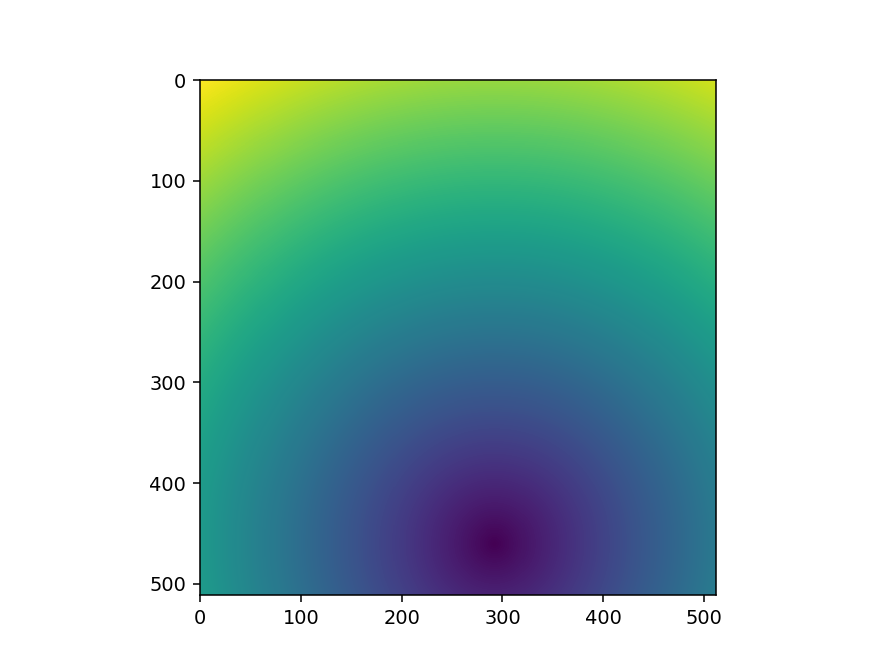

In [106]:
from matplotlib import pyplot
pyplot.figure()
problem = create_id22_17_problem()
pyplot.imshow(reduce_problem(problem, (512, 512)).image)
pyplot.show()

In [109]:
import timeit
import collections

TimeCollect = collections.namedtuple('TimeCollect', ['image_size',
                                                     'algorithm_name',
                                                     'precache_t', 'precache_dt',
                                                     'postprocess_t', 'postprocess_dt',
                                                     'compute_t', 'compute_dt'])

def get_t_dt(array):
    array = numpy.array(array)
    return array.mean(), array.max() - array.mean()


def collect_computation(result, algorithm_name, algorithm_factory, problem):
    values = problem.values

    algo = algorithm_factory(problem.image, problem.mask)
    scope = dict(globals())
    scope.update(locals())

    compute_time = timeit.repeat("[algo.iso_contour(v) for v in values]", number=10, globals=scope)
    compute_time = get_t_dt(compute_time)
    t = TimeCollect(algorithm_name=algorithm_name,
                    image_size=problem.image.shape[0] * problem.image.shape[1],
                    precache_t=0,
                    precache_dt=0,
                    postprocess_t=0,
                    postprocess_dt=0,
                    compute_t=compute_time[0],
                    compute_dt=compute_time[1])
    result.append(t)


problem_16mpx_17rings = create_id22_17_problem()
problem_4mpx_17rings = reduce_problem(problem_16mpx_17rings, (2096, 2096))
problem_1mpx_17rings = reduce_problem(problem_16mpx_17rings, (1024, 1024))
problem_250kpx_17rings = reduce_problem(problem_16mpx_17rings, (512, 512))

problems = [
    problem_16mpx_17rings,
    problem_4mpx_17rings,
    problem_1mpx_17rings,
    problem_250kpx_17rings]

algorithms = [
    ("MarchingSquareCythonArray", lambda i, m: MarchingSquareCythonArray(i, m)),
    ("MarchingSquareCythonArrayOpt", lambda i, m: MarchingSquareCythonArrayOpt(i, m)),
    ("MarchingSquareSciKitImage", lambda i, m: MarchingSquareSciKitImage(i, m))]

collected_result = []
for problem in problems:
    print("Compute problem: image size = %s, iso contour count = %d" % (problem.image.shape, len(problem.values)))
    for name, factory in algorithms:
        print("- %s" % (name))
        # collect_computation(collected_result, name, factory, problem)

print(collected_result)

Compute problem: image size = (4096, 4096), iso contour count = 17
- MarchingSquareCythonArray
- MarchingSquareCythonArrayOpt
- MarchingSquareSciKitImage
Compute problem: image size = (2096, 2096), iso contour count = 17
- MarchingSquareCythonArray
- MarchingSquareCythonArrayOpt
- MarchingSquareSciKitImage
Compute problem: image size = (1024, 1024), iso contour count = 17
- MarchingSquareCythonArray
- MarchingSquareCythonArrayOpt
- MarchingSquareSciKitImage
Compute problem: image size = (512, 512), iso contour count = 17
- MarchingSquareCythonArray
- MarchingSquareCythonArrayOpt
- MarchingSquareSciKitImage
[]


In [120]:
collected_result = [TimeCollect(image_size=16777216, algorithm_name='MarchingSquareCythonArray', precache_t=0, precache_dt=0, postprocess_t=0, postprocess_dt=0, compute_t=24.767667616334318, compute_dt=0.028303086667921917), TimeCollect(image_size=16777216, algorithm_name='MarchingSquareCythonArrayOpt', precache_t=0, precache_dt=0, postprocess_t=0, postprocess_dt=0, compute_t=16.493696789665893, compute_dt=0.005905359334672511), TimeCollect(image_size=16777216, algorithm_name='MarchingSquareSciKitImage', precache_t=0, precache_dt=0, postprocess_t=0, postprocess_dt=0, compute_t=18.5463472929999, compute_dt=0.009933503001473554), TimeCollect(image_size=4393216, algorithm_name='MarchingSquareCythonArray', precache_t=0, precache_dt=0, postprocess_t=0, postprocess_dt=0, compute_t=6.513181622334135, compute_dt=0.0017205866667309166), TimeCollect(image_size=4393216, algorithm_name='MarchingSquareCythonArrayOpt', precache_t=0, precache_dt=0, postprocess_t=0, postprocess_dt=0, compute_t=4.344499907000379, compute_dt=0.004056219001843608), TimeCollect(image_size=4393216, algorithm_name='MarchingSquareSciKitImage', precache_t=0, precache_dt=0, postprocess_t=0, postprocess_dt=0, compute_t=7.258512855000542, compute_dt=0.008144936998481178), TimeCollect(image_size=1048576, algorithm_name='MarchingSquareCythonArray', precache_t=0, precache_dt=0, postprocess_t=0, postprocess_dt=0, compute_t=1.5564995149992076, compute_dt=0.003955693997947263), TimeCollect(image_size=1048576, algorithm_name='MarchingSquareCythonArrayOpt', precache_t=0, precache_dt=0, postprocess_t=0, postprocess_dt=0, compute_t=1.0362244389992459, compute_dt=0.0013389280017388483), TimeCollect(image_size=1048576, algorithm_name='MarchingSquareSciKitImage', precache_t=0, precache_dt=0, postprocess_t=0, postprocess_dt=0, compute_t=3.935129553333051, compute_dt=0.12711125266772205), TimeCollect(image_size=262144, algorithm_name='MarchingSquareCythonArray', precache_t=0, precache_dt=0, postprocess_t=0, postprocess_dt=0, compute_t=0.3851117750006476, compute_dt=0.0009667900024699638), TimeCollect(image_size=262144, algorithm_name='MarchingSquareCythonArrayOpt', precache_t=0, precache_dt=0, postprocess_t=0, postprocess_dt=0, compute_t=0.2570725649990588, compute_dt=0.0031601790008911057), TimeCollect(image_size=262144, algorithm_name='MarchingSquareSciKitImage', precache_t=0, precache_dt=0, postprocess_t=0, postprocess_dt=0, compute_t=0.9826933999999407, compute_dt=0.11473882299954619)]

In [121]:
problem_16mpx_17rings = create_id22_17_problem()
problems = [
    reduce_problem(problem_16mpx_17rings, (3000, 3000)),
    reduce_problem(problem_16mpx_17rings, (2500, 2500)),
    reduce_problem(problem_16mpx_17rings, (1500, 1500))]

for problem in problems:
    print("Compute problem: image size = %s, iso contour count = %d" % (problem.image.shape, len(problem.values)))
    for name, factory in algorithms:
        print("- %s" % (name))
        collect_computation(collected_result, name, factory, problem)

Compute problem: image size = (3000, 3000), iso contour count = 17
- MarchingSquareCythonArray
- MarchingSquareCythonArrayOpt
- MarchingSquareSciKitImage
Compute problem: image size = (2500, 2500), iso contour count = 17
- MarchingSquareCythonArray
- MarchingSquareCythonArrayOpt
- MarchingSquareSciKitImage
Compute problem: image size = (1500, 1500), iso contour count = 17
- MarchingSquareCythonArray
- MarchingSquareCythonArrayOpt
- MarchingSquareSciKitImage


In [124]:
collected_result = [TimeCollect(image_size=16777216, algorithm_name='MarchingSquareCythonArray', precache_t=0, precache_dt=0, postprocess_t=0, postprocess_dt=0, compute_t=24.767667616334318, compute_dt=0.028303086667921917),
 TimeCollect(image_size=16777216, algorithm_name='MarchingSquareCythonArrayOpt', precache_t=0, precache_dt=0, postprocess_t=0, postprocess_dt=0, compute_t=16.493696789665893, compute_dt=0.005905359334672511),
 TimeCollect(image_size=16777216, algorithm_name='MarchingSquareSciKitImage', precache_t=0, precache_dt=0, postprocess_t=0, postprocess_dt=0, compute_t=18.5463472929999, compute_dt=0.009933503001473554),
 TimeCollect(image_size=4393216, algorithm_name='MarchingSquareCythonArray', precache_t=0, precache_dt=0, postprocess_t=0, postprocess_dt=0, compute_t=6.513181622334135, compute_dt=0.0017205866667309166),
 TimeCollect(image_size=4393216, algorithm_name='MarchingSquareCythonArrayOpt', precache_t=0, precache_dt=0, postprocess_t=0, postprocess_dt=0, compute_t=4.344499907000379, compute_dt=0.004056219001843608),
 TimeCollect(image_size=4393216, algorithm_name='MarchingSquareSciKitImage', precache_t=0, precache_dt=0, postprocess_t=0, postprocess_dt=0, compute_t=7.258512855000542, compute_dt=0.008144936998481178),
 TimeCollect(image_size=1048576, algorithm_name='MarchingSquareCythonArray', precache_t=0, precache_dt=0, postprocess_t=0, postprocess_dt=0, compute_t=1.5564995149992076, compute_dt=0.003955693997947263),
 TimeCollect(image_size=1048576, algorithm_name='MarchingSquareCythonArrayOpt', precache_t=0, precache_dt=0, postprocess_t=0, postprocess_dt=0, compute_t=1.0362244389992459, compute_dt=0.0013389280017388483),
 TimeCollect(image_size=1048576, algorithm_name='MarchingSquareSciKitImage', precache_t=0, precache_dt=0, postprocess_t=0, postprocess_dt=0, compute_t=3.935129553333051, compute_dt=0.12711125266772205),
 TimeCollect(image_size=262144, algorithm_name='MarchingSquareCythonArray', precache_t=0, precache_dt=0, postprocess_t=0, postprocess_dt=0, compute_t=0.3851117750006476, compute_dt=0.0009667900024699638),
 TimeCollect(image_size=262144, algorithm_name='MarchingSquareCythonArrayOpt', precache_t=0, precache_dt=0, postprocess_t=0, postprocess_dt=0, compute_t=0.2570725649990588, compute_dt=0.0031601790008911057),
 TimeCollect(image_size=262144, algorithm_name='MarchingSquareSciKitImage', precache_t=0, precache_dt=0, postprocess_t=0, postprocess_dt=0, compute_t=0.9826933999999407, compute_dt=0.11473882299954619),
 TimeCollect(image_size=9000000, algorithm_name='MarchingSquareCythonArray', precache_t=0, precache_dt=0, postprocess_t=0, postprocess_dt=0, compute_t=13.3465953090005, compute_dt=0.05738483500075198),
 TimeCollect(image_size=9000000, algorithm_name='MarchingSquareCythonArrayOpt', precache_t=0, precache_dt=0, postprocess_t=0, postprocess_dt=0, compute_t=8.856666712666387, compute_dt=0.004319310332599358),
 TimeCollect(image_size=9000000, algorithm_name='MarchingSquareSciKitImage', precache_t=0, precache_dt=0, postprocess_t=0, postprocess_dt=0, compute_t=11.611747229665829, compute_dt=0.11142378233368255),
 TimeCollect(image_size=6250000, algorithm_name='MarchingSquareCythonArray', precache_t=0, precache_dt=0, postprocess_t=0, postprocess_dt=0, compute_t=9.309840262332727, compute_dt=0.03702277066622628),
 TimeCollect(image_size=6250000, algorithm_name='MarchingSquareCythonArrayOpt', precache_t=0, precache_dt=0, postprocess_t=0, postprocess_dt=0, compute_t=6.213685669665817, compute_dt=0.023619507331507528),
 TimeCollect(image_size=6250000, algorithm_name='MarchingSquareSciKitImage', precache_t=0, precache_dt=0, postprocess_t=0, postprocess_dt=0, compute_t=9.03884656000082, compute_dt=0.07790494900109479),
 TimeCollect(image_size=2250000, algorithm_name='MarchingSquareCythonArray', precache_t=0, precache_dt=0, postprocess_t=0, postprocess_dt=0, compute_t=3.360809662665512, compute_dt=0.015091351332860992),
 TimeCollect(image_size=2250000, algorithm_name='MarchingSquareCythonArrayOpt', precache_t=0, precache_dt=0, postprocess_t=0, postprocess_dt=0, compute_t=2.2432616139994934, compute_dt=0.011316568998154253),
 TimeCollect(image_size=2250000, algorithm_name='MarchingSquareSciKitImage', precache_t=0, precache_dt=0, postprocess_t=0, postprocess_dt=0, compute_t=5.236860288333749, compute_dt=0.00017334666578516789)]

In [115]:
import numpy
from matplotlib import pyplot
import pylab

def get_algorithms(collected_result):
    result = set([r.algorithm_name for r in collected_result])
    result = sorted(result)
    return result

def get_result_per_algorithm(collected_result, algorithm_name):
    result = [r for r in collected_result if r.algorithm_name == algorithm_name]
    result = sorted(result, key=lambda r: r.image_size)
    return result

colors = ["green", "yellow", "orange", "red"]

<IPython.core.display.Javascript object>


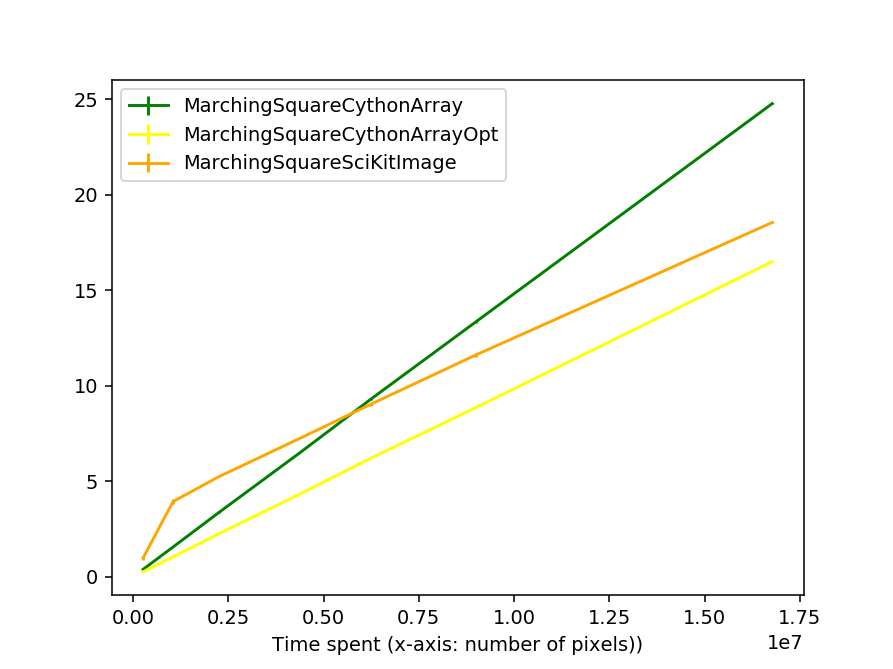

<IPython.core.display.Javascript object>


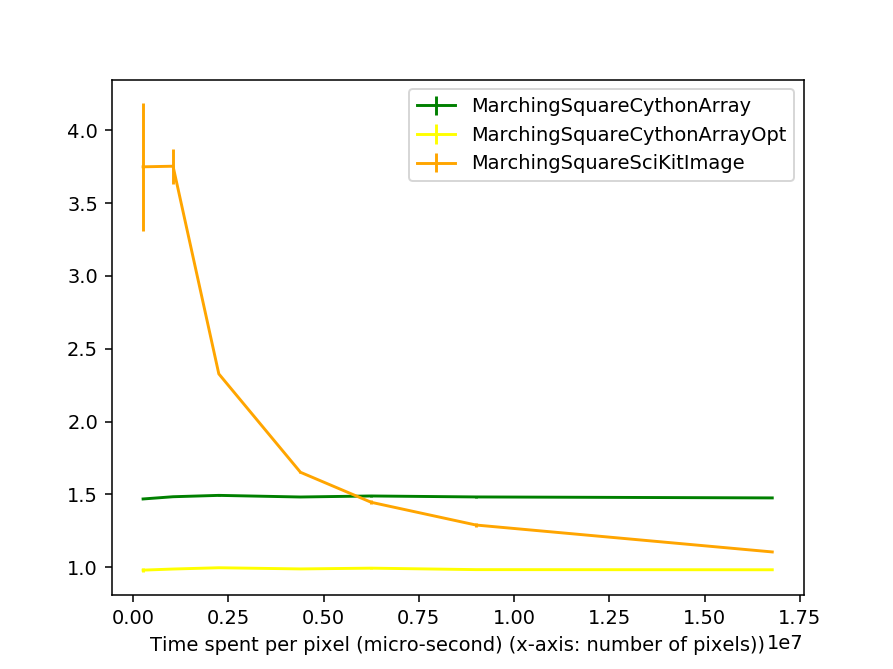

In [130]:
def plot_computation(collected_result):
    algorithms = get_algorithms(collected_result)

    pyplot.figure()
    for i, algorithm in enumerate(algorithms):
        result = get_result_per_algorithm(collected_result, algorithm)
        color = colors[i % len(colors)]
        x = numpy.array([r.image_size for r in result]) + 1
        compute_y = numpy.array([r.compute_t for r in result])
        compute_error = numpy.array([r.compute_dt for r in result])
        pyplot.errorbar(x=x, y=compute_y, yerr=compute_error, color=color, linestyle="-", label="%s" % (algorithm))

    pylab.legend()
    # pyplot.gca().set_xscale("log", nonposx='clip')
    pylab.xlabel("Time spent (x-axis: number of pixels))")
    pyplot.legend
    pyplot.show()

def plot_computation_per_pixels(collected_result):
    algorithms = get_algorithms(collected_result)

    pyplot.figure()
    for i, algorithm in enumerate(algorithms):
        result = get_result_per_algorithm(collected_result, algorithm)
        color = colors[i % len(colors)]
        x = numpy.array([r.image_size for r in result]) + 1
        image_sizes = numpy.array([r.image_size for r in result])
        compute_y = numpy.array([r.compute_t for r in result]) / image_sizes * 1000000
        compute_error = numpy.array([r.compute_dt for r in result]) / image_sizes * 1000000
        pyplot.errorbar(x=x, y=compute_y, yerr=compute_error, color=color, linestyle="-", label="%s" % (algorithm))

    pylab.legend()
    # pyplot.gca().set_xscale("log", nonposx='clip')
    pylab.xlabel("Time spent per pixel (micro-second) (x-axis: number of pixels))")
    pyplot.legend
    pyplot.show()

# Check computation time vs precache time
plot_computation(collected_result)
plot_computation_per_pixels(collected_result)